
# Importing

In [ ]:
# colab setting
!pip install GraphRicciCurvature
!pip install scikit-learn

# import sys
# sys.path.append("../")


import networkx as nx
import numpy as np
import math
import random

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
import community.community_louvain as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 29.3 MB/s eta 0:00:00


In [ ]:
import GraphRicciCurvature
print(GraphRicciCurvature.__version__)

0.5.3.1


# Helper Functions

In [ ]:
def draw_graph(G, clustering_label="club"):
    """
    A helper function to draw a nx graph with community.
    """
    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    node_color = le.fit_transform(list(complex_list.values()))


    nx.draw_spring(G, nodelist=G.nodes(),
                   node_color=node_color,
                   cmap=plt.cm.rainbow,
                   alpha=0.8)



def show_results(G, curvature="ricciCurvature"):
    """
    A helper function to show summary of curvature in a graph

    # parameters
     - G : networkx graph
    # returns
     - plot of summaries
    """
    # Print the first five results
    print("Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2][curvature]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, curvature).values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()


def ARI(G, clustering, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)


def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0):
    """

    Performs a graph "surgery" by removing edges with a weight above a specified threshold,
    then evaluates the resulting graph structure.

    Parameters
    ----------
    G_origin : nx.Graph
        The original graph where edges will be evaluated and potentially removed based on the
        specified weight attribute.
    weight : str, optional
        The name of the edge attribute to use as the criterion for removal. This attribute is often
        used to represent Ricci flow metrics or other forms of edge significance. Default is "weight".
    cut : float, optional
        The threshold value above which edges are removed. If not specified or set to 0, a default
        heuristic is used to determine a cutoff point based on the distribution of the weight values
        across all edges.

    Returns
    -------
    tuple
        A tuple containing several metrics evaluating the graph post-surgery:
        - The number of edges removed.
        - The number of nodes remaining in the graph.
        - The number of edges remaining in the graph.
        - The modularity of the graph, assessing the quality of division into communities.
        - The Adjusted Rand Index (ARI) based on the detected communities within the graph.
        - The modified graph (`nx.Graph`) after the removal of selected edges.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    G.remove_edges_from(to_cut)
    cc = list(nx.connected_components(G))


    return len(to_cut),G.number_of_nodes(), G.number_of_edges(), nx.algorithms.community.quality.modularity(G, cc), ARI(G, cc), G

# Missing Edges Helpers

In [ ]:
def block_model_with_edge_removal(block_sizes, prob_matrix, p = 0, method="uniform"):
    """
    Generates a block model graph and removes edges according to the specified method:
    uniformly, by degree, or based on inter-community probabilities.

    Parameters:
    - block_sizes : array-like, the size of each community.
    - prob_matrix : array-like, matrix of probabilities for edge creation between communities.
    - p : float, array-like, or matrix, specifying the probability or proportions of edges to remove.
      Interpreted based on the 'method' parameter.
    - method : str, method for edge removal ("uniform", "degree", or "weighted").

    Returns:
    - G : networkx graph, a graph with edges removed according to the specified method.
    """

    # Generate a stochastic block model graph
    G = nx.generators.community.stochastic_block_model(block_sizes, prob_matrix)

    # Assign 'block' attribute to each node based on its community
    club_attribute = {node: G.nodes[node]['block'] for node in G.nodes}
    nx.set_node_attributes(G, club_attribute, name='club')

    if method == "uniform" or method == "degree":
        edges_to_consider = list(G.edges(data=True))
    else:
        edges_to_consider = G.edges(data='block')

    if method == "uniform":
        for edge in edges_to_consider:
            if random.random() < p:
                G.remove_edge(edge[0], edge[1])

    elif method == "degree":
        for node in list(G.nodes()):
            adjacent_edges = list(G.edges(node))
            num_to_remove = int(len(adjacent_edges) * p)
            edges_to_remove = random.sample(adjacent_edges, num_to_remove)
            G.remove_edges_from(edges_to_remove)

    elif method == "weighted":
        if not isinstance(p, (list, np.ndarray)) or np.shape(p) != (len(block_sizes), len(block_sizes)):
            raise ValueError("For 'weighted' method, p must be a matrix matching the number of communities.")
        to_remove = set()
        for edge in edges_to_consider:
            source_block = G.nodes[edge[0]]['block']
            target_block = G.nodes[edge[1]]['block']
            removal_prob = p[source_block][target_block]

            if random.random() < removal_prob:
                to_remove.add(edge)
        for edge in to_remove:
            G.remove_edge(edge[0], edge[1])

    else:
        raise ValueError("Invalid method specified. Choose 'uniform', 'degree', or 'weighted'.")

    return G



def edges_between_communities(G):
    # Extract community information from each node
    communities = nx.get_node_attributes(G, 'block')
    unique_communities = set(communities.values())

    # Map communities to indices
    community_indices = {community: i for i, community in enumerate(unique_communities)}

    # Initialize the matrix with zeros
    matrix_size = len(unique_communities)
    community_matrix = np.zeros((matrix_size, matrix_size), dtype=int)

    # Iterate over each edge to count the edges between communities
    for u, v in G.edges():
        community_u = communities[u]
        community_v = communities[v]
        i = community_indices[community_u]
        j = community_indices[community_v]
        community_matrix[i][j] += 1
        if i != j:  # If the edge is not within the same community, increment the symmetric cell
            community_matrix[j][i] += 1

    return community_matrix


# Two-neighborhood Weighted Analysis

In [ ]:
# Definitions for initial problem

block_sizes = [100, 100]
p_inter, p_intra = 0.25, 0.5
prob_matrix = [
    [p_intra, p_inter],
    [p_inter, p_intra]
]

remove_prob_matrix = [
    [0.8, 0.7],
    [0.7, 0.8]
]

model = block_model_with_edge_removal(block_sizes,
                                      prob_matrix=prob_matrix,
                                      p = remove_prob_matrix,
                                      method = "weighted")
edges_between_communities(model)

array([[518, 757],
       [757, 502]])

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:GraphRicciCurvature:Number of nodes: 200
TRACE:GraphRicciCurvature:Number of edges: 2465
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:0.049002 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:3.234039 secs for Ricci curvature computation.


Graph, first 5 edges: 
Ricci curvature of edge (0,6) is 0.045652
Ricci curvature of edge (0,8) is 0.027950
Ricci curvature of edge (0,12) is 0.034585
Ricci curvature of edge (0,32) is 0.032091
Ricci curvature of edge (0,39) is 0.007033


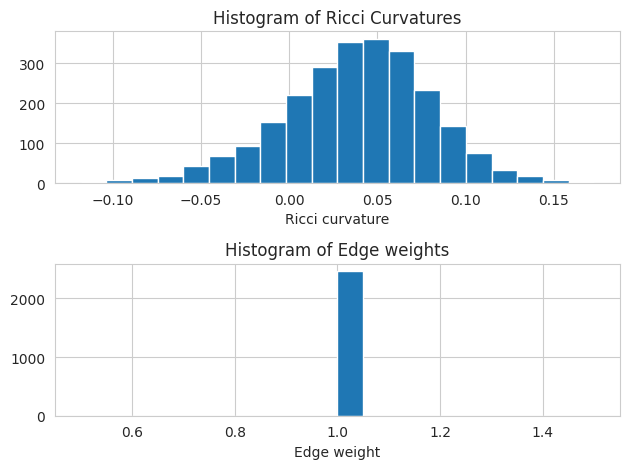

In [ ]:
initial = OllivierRicci(model, alpha=0.5, verbose="TRACE")
initial.compute_ricci_curvature()
curve_initial = initial.G.copy()  # save an intermediate result

show_results(curve_initial)

In [ ]:
def weighted_ricci_simulation(G):
  orf = OllivierRicci(G, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")
  orf.compute_ricci_flow(iterations=10)
  G_rf = orf.G.copy()

  return my_surgery(G_rf, cut = 1.5)
weighted_data = dict()

In [ ]:
for i in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
  for j in [0.5, 0.7, 0.8, 0.85, 0.9, 0.95]:
    remove_prob_matrix = [
      [i, j],
      [j, i]]
    model = block_model_with_edge_removal(block_sizes,
                                      prob_matrix=prob_matrix,
                                      p = remove_prob_matrix,
                                      method = "weighted")
    num_cut, n, num_edges, mod, ari, G = weighted_ricci_simulation(model)
    weighted_data[(i, j)] = (num_cut, n, num_edges, mod, ari, G)


INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:3.244409 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:2.118137 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:2.048209 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:2.527556 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:3.775246 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:2.146513 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 5 === 
INFO:GraphRicciCurvature:2.032844 secs for Ricc

In [ ]:
import pandas as pd
weighted_summary = pd.DataFrame(weighted_data).iloc[:5,]
weighted_summary['Names'] = ['Num_cut', 'Num nodes', 'num edges', 'Modularity', 'ARI']
weighted_summary.set_index('Names', inplace = True)
weighted_summary

0.50                                        0.70              \
            0.50  0.70  0.80  0.85      0.90      0.95  0.50  0.70  0.80   
Names                                                                      
Num_cut        0     2   400   387       270       128     0     0     0   
Num nodes    200   200   200   200       200       200   200   200   200   
num edges   3713  3215  2533  2540      2468      2442  2652  2238  1975   
Modularity  -0.0  -0.0   0.0   0.0  0.499947  0.499947   0.0   0.0  -0.0   
ARI          0.0   0.0   0.0   0.0       1.0       1.0   0.0   0.0   0.0   

                  ... 0.90                 0.95                           
            0.85  ... 0.80 0.85 0.90 0.95  0.50 0.70 0.80 0.85 0.90 0.95  
Names             ...                                                     
Num_cut       11  ...    0    0    0    0     0    0    0    0    0    8  
Num nodes    200  ...  200  200  200  200   200  200  200  199  200  198  
num edges   1912  ...  940  863  774  621  1539  965  760  656  534  375  
Modularity  -0.0  ... -0.0 -0.0 -0.0  0.0   0.0 -0.0  0.0  0.0  0.0 -0.0  
ARI          0.0  ...  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

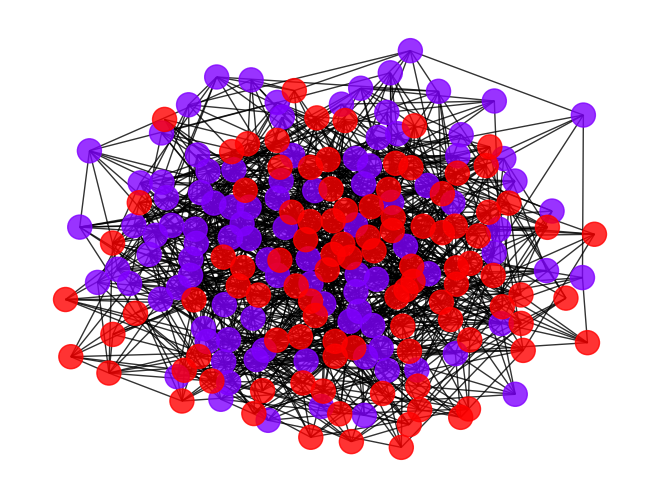

In [ ]:
draw_graph(weighted_data[(0.85,0.85)][5])

In [ ]:
!pip install pandas openpyxl

file_path = 'weighted_data.xlsx'

# Use the to_excel method to export the DataFrame
weighted_summary.to_excel(file_path, engine='openpyxl')


In [ ]:
import os
os. getcwd()

'/content'